In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import shap
shap.initjs()

from catboost import Pool, cv, CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('../data/raw/training_v2.csv')

In [3]:
df.drop('encounter_id', axis=1, inplace=True)
df.drop('patient_id', axis=1, inplace=True)
df.drop('hospital_id', axis=1, inplace=True)
df.drop('icu_id', axis=1, inplace=True)

In [4]:
col_list = []
with open("../data/raw/del_columns.txt", "r") as f:
    for line in f:
        col_list.append(line[:-1])
        
df.drop(columns=col_list, inplace=True, axis=1)

In [5]:
df.shape

(91713, 93)

In [6]:
def preprocess_features(df):
    df['gender'] = df['gender'].fillna(df['gender'].value_counts().index[0])
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})

    df['ethnicity'] = df['ethnicity'].fillna("Other/Unknown")
    df["ethnicity"] = df['ethnicity'].str.lower()
        
    und_diag = {"Undefined diagnoses": "Undefined Diagnoses"}
    df["apache_2_bodysystem"].replace(und_diag, inplace = True)
    
    df['apache_2_bodysystem'] = df['apache_2_bodysystem'].fillna("nan")
    df['apache_2_bodysystem'] = df['apache_2_bodysystem'].str.lower()

    df['apache_3j_bodysystem'] = df['apache_3j_bodysystem'].fillna("nan")
    df['apache_3j_bodysystem'] = df['apache_3j_bodysystem'].str.lower()
    
    df["age"].fillna(int(df["age"].mean()), inplace=True)
    d = {range(1, 50): 1, range(50, 65): 2, range(65, 75): 3, range(75, 100): 4}
    df["age"] = df["age"].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    
    df.dropna(subset=['heart_rate_apache', 'temp_apache'], inplace=True)
    
    d1 = {range(25, 80): 1, range(80, 120): 2, range(120, 150): 3, range(150, 180): 4, range(180, 200): 5}
    df["heart_rate_apache"] = df["heart_rate_apache"].apply(lambda x: next((v for k, v in d1.items() if x in k), 0))

    df = pd.get_dummies(df, columns=["age", "heart_rate_apache"])
    
    d2 = {range(int(df["temp_apache"].min()), 37): 0, range(37, int(df["temp_apache"].max())+1): 1}
    df["temp_apache"] = df["temp_apache"].apply(lambda x: next((v for k, v in d2.items() if x in k), 0))
    
    df["urineoutput_apache"].fillna(df["urineoutput_apache"].mean(), inplace=True)
    
    # normalize urineoutput_apache
    x = df[['urineoutput_apache']].values.astype(float)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df["urineoutput_apache"] = x_scaled

    return df

In [7]:
def evaluate(y_true, scores, preds):
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    roc_auc = roc_auc_score(y_true, scores)
    auprc = average_precision_score(y_true, scores)
    
    print("Accuracy:  {:.4f}".format(acc))
    print("Precision: {:.4f}".format(precision))
    print("Recall:    {:.4f}".format(recall))
    print("F1-score:  {:.4f}".format(f1))
    print("ROCAUC:    {:.4f}".format(roc_auc))
    print("AUPRC:     {:.4f}".format(auprc))

In [8]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [9]:
def plot_precision_recall_curve(y_test, probs):
    precision, recall, threshold = precision_recall_curve(y_test, probs)
    auc_score = auc(recall, precision)
    
    plt.title('2-class Precision-Recall curve')
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.plot(recall, precision, 'r', marker='.')
    plt.show()

In [10]:
clean_df = preprocess_features(df)
df["urineoutput_apache"].describe()

count    41832.000000
mean      1739.475400
std       1444.267680
min          0.000000
25%        745.005600
50%       1389.916800
75%       2324.095200
max       8716.669632
Name: urineoutput_apache, dtype: float64

In [11]:
y = clean_df.hospital_death
X = clean_df.drop(columns="hospital_death")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [12]:
df = X_train.join(y_train)
pos_df = df[df.hospital_death == 1]
neg_df = df[df.hospital_death == 0].sample(n=pos_df.shape[0], random_state=1)

df_balanced = pd.concat([pos_df, neg_df])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [13]:
y_train = df_balanced.hospital_death
X_train = df_balanced.drop(columns="hospital_death")

In [14]:
categorical_cols = list(df.columns[df.dtypes == "object"])

In [18]:
# for imbalanced dataset 
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = CatBoostClassifier(
    depth= 4,
    rsm=0.8,
    l2_leaf_reg=13,
    loss_function="Logloss",
    eval_metric="AUC",
    scale_pos_weight=scale_pos_weight,
    one_hot_max_size=16,
    cat_features=categorical_cols,
)

start_time = time.time()
model.fit(X_train, y_train, plot=True, silent=True)
print("--- %s seconds ---" % (time.time() - start_time))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

--- 8.218088865280151 seconds ---


In [16]:
y_true = y_test.values

y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.8061
Precision: 0.2773
Recall:    0.8146
F1-score:  0.4138
ROCAUC:    0.8921
AUPRC:     0.5154


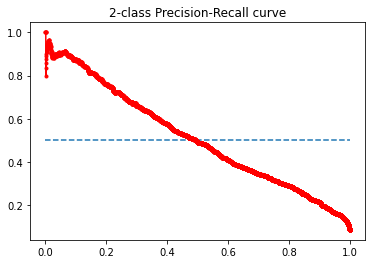

In [17]:
plot_precision_recall_curve(y_true, y_score[:, 1])

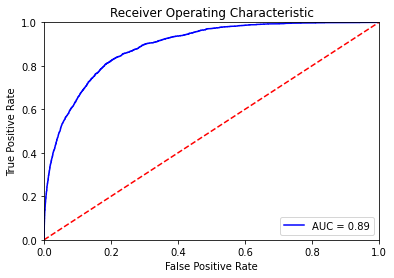

In [18]:
plot_roc_curve(y_true, y_score[:, 1])

In [19]:
print(model.get_best_score())

{'learn': {'Logloss': 0.3340230703599255}}


In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


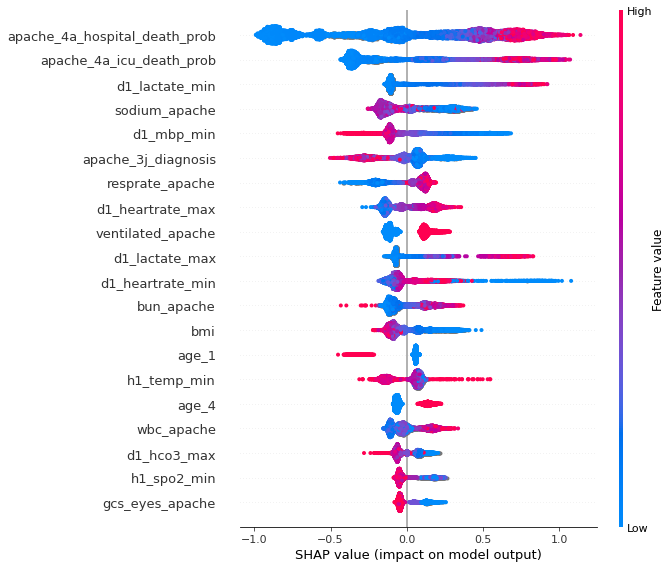

In [21]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)
f.savefig("../reports/3.2_summary_plot.png", bbox_inches='tight', dpi=600)

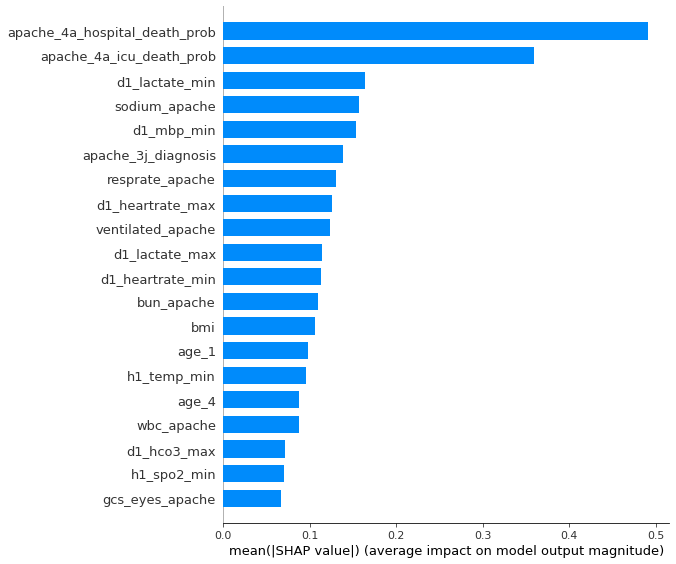

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

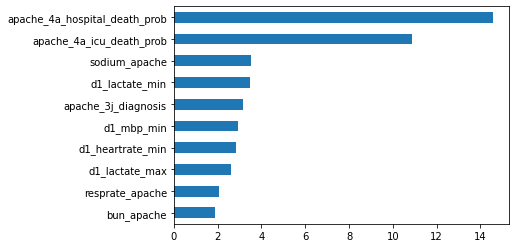

In [23]:
feature_importances = model.feature_importances_
feat_importances = pd.Series(feature_importances, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh').invert_yaxis()